# Non-Gaussian Measurements Tutorial 2

## Overview

There are many, many ways in which non-Gaussian / ambiguous measurements occur, this tutorial will simply pick one common example to illustrate the basic concepts.  We ground the tutorial in an example: imagine a wheeled robot travelling along in a straight line, using wheel encoders to estimate the distance travelled.  There is, however, a quirk, from time to time the robot gets stuck on something and the wheel's spin for a few rotations before progress continues.  We assume that our software is able to detect when the wheels are slipping, but the process is only 40% accurate.  In this tutorial we will build a basic robot localization process that can handle "bad" measurement data.  We restrict this to a one dimensional example with only a few variables and factors, to help familiarize yourself with multi-modal beliefs.  

This example shows one of four mechanisms by which non-Gaussian behavior can get introduced into a factor graph solution, see other tutorials for other mechanisms.  We will build a factor graph that contains multi-modal belief as well as `Uniform` and `Rayleigh` distributions, to help familiarize non-Gaussian measurements.   The ambiguous measurement example shown in this tutorial can readily be incorporated in other use cases, and also illustrates how consensus can occur when more information is included -- i.e. reducing uncertainties to unimodal marignal beliefs on each variable.

This tutorial introduces non-Gaussian baehavior through non-Gaussian measurements in the factor graph.  This tutorial shows how measurements do not have to follow a unimodal bell curve (i.e. normal/Gaussian), but can instead introduce non-Gaussian beliefs and let the joint inference find the best marginal posterior estimates on each of the desired variables in the factor graph.  The tutorial shows a multi-modal uncertainty can be introduced from non-Gaussian measurements, and then transmitted through the system.  


### Signatures Used

`ContinuousScalar`, `Prior`, `LinearRelative`, `Mixture`, `Normal`, `plotBelief`, `plotDFG`, `isInitialized`, `initAll!`, `solveGraph!`

## Ambiguous Data Example

To start, the two major mathematical packages are brought into scope.

In [ ]:
# Install packages if not included in your environment by default for whatever reason.
import Pkg; [Pkg.add(s) for s in ["IncrementalInference";"Logging";"GraphPlot";"RoMEPlotting"]];

In [47]:
# suppress unnecessary printouts in the notebook
using Logging
Logging.disable_logging(Logging.Warn)
# library used for graph visualizations
using GraphPlot
# IncrementalInference is a package dependency of the umbrella Caesar suite.
using IncrementalInference
# plot visualizations
using RoMEPlotting
Gadfly.set_default_plot_size(20cm,15cm)

 
## Starting a 1D Factor Graph

### Variable, `ContinuousScalar`

The next step is to describe the inference problem with a graphical model with any of the existing concrete types that inherit from  `<: AbstractDFG`.
The first step is to create an empty factor graph object and start populating it with variable nodes.
The variable nodes are identified by `Symbol`s, namely `x0, x1, x2, x3`.


In [118]:
# Start with an empty factor graph
fg = initfg()

# add the first node
addVariable!(fg, :x0, ContinuousScalar)

DFGVariable{Position...}
  manifold:   TranslationGroup(1; field = ℝ)
  timestamp:  2022-04-04T19:39:03.895-07:00
   nstime:    0 nanoseconds
  label:      x0
  solvable:   1
  tags:       Set([:VARIABLE])
  # VND solveKeys=    (1)
  # initialized:      (true=0,false=1)
  # marginalized:     (true=0,false=1)
    :default <-- VariableNodeData
      initilized:        false
      marginalized:      false
      size bel. samples: (100,)
      kde bandwidths:    0.0
     VNDs: [:default]
  # PPE solveKeys=    (0)
  VariableType: Position{1}


### Prior Factor, (Euclidean(1))

Factor graphs are bipartite graphs with `factors` that act as mathematical structure between interacting `variables`.
After adding node `x0`, a singleton factor of type `Prior` (which was defined by the user earlier) is 'connected to' variable node `x0`.
This unary factor is taken as a `Distributions.Normal` distribution with zero mean and a standard devitation of `1`.


In [119]:
# this is unary (prior) factor and does not immediately trigger autoinit of :x0.
addFactor!(fg, [:x0], Prior(Normal(0,1)))

DFGFactor{CommonConvWrapper{Prior...}}
  timestamp:     2022-04-04T19:39:06.284-07:00
   nstime:       0 nanoseconds
  label:         x0f1
  solvable:      1
  VariableOrder: [:x0]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: Prior{Normal{Float64}}
Z:
Normal{Float64}(μ=0.0, σ=1.0)


**Note**, this example is using just `Prior`, which is a simplification for the sake of this tutorial.  Look out for on-manifold prior factors in other code examples.

### Visualizing Graph Topology

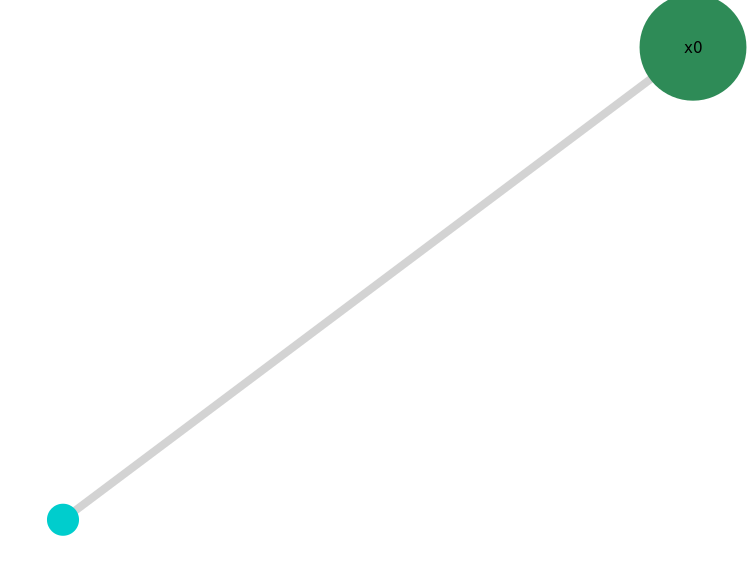

In [120]:
DFG.plotDFG(fg)

The topological graph plot above shows the two node factor graph, one variable and one prior factor.  This example uses graph-based automatic variable initialization which was discussed in ICRA 2022 Tutorial 1.

### Next Variable and Relative Factor

Now let's add a second variable `x1`, and connect it to `x0` with a `LinearRelative` factor.

In [121]:
addVariable!(fg, :x1, ContinuousScalar)
# P(Z | :x1 - :x0 ) where Z ~ Normal(10,1)
addFactor!(fg, [:x0, :x1], LinearRelative(Normal(10.0,1)))

DFGFactor{CommonConvWrapper{LinearRelative...}}
  timestamp:     2022-04-04T19:39:11.699-07:00
   nstime:       0 nanoseconds
  label:         x0x1f1
  solvable:      1
  VariableOrder: [:x0, :x1]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: LinearRelative{1, Normal{Float64}}
Z:
Normal{Float64}(μ=10.0, σ=1.0)


### Visualizing the Variable Probability Belief

The `RoMEPlotting.jl` package allows visualization (plotting) of the belief state over any of the variable nodes.
Remember the first time executions are slow given required code compilation, and that future versions of these package will use more precompilation to reduce first execution running cost.

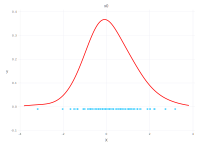

In [122]:
# allow the first run some time to complete Julia JIT compiling of plottinng functions.
plotBelief(fg, :x0)


By forcing the initialization of `:x1` and plotting its belief estimate,

In [123]:
solveGraph!(fg);

Solve Progress: approx max 24, at iter 11 	 Time: 0:00:00

Solve Progress: approx max 24, at iter 11 	 Time: 0:00:00


Building Bayes net...
Find potential functions for each clique


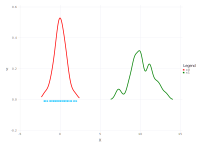

In [124]:
plotBelief(fg, [:x0, :x1])

the predicted influence of the `P(Z| X1 - X0) = LinearRelative(Normal(10, 1))` is shown by the red trace.
The red trace (predicted belief of `x1`) is noting more than the approximated convolution of the current marginal belief of `x0` with the conditional belief described by `P(Z | X1 - X0)`.


### Mixture Distribution on Next Relative Factor (Wheel Slip)

As the robot continues to drive from `x1` to `x2`, the robot software detects wheel slip has occurred.  Here then is the ciritical point, how should the next odometry measurement incorporate this ambiguous information.  First, we add the next `ContinuousScalar` variable `x2` as before.  

In [125]:
addVariable!(fg, :x2, ContinuousScalar)

DFGVariable{Position...}
  manifold:   TranslationGroup(1; field = ℝ)
  timestamp:  2022-04-04T19:39:22.503-07:00
   nstime:    0 nanoseconds
  label:      x2
  solvable:   1
  tags:       Set([:VARIABLE])
  # VND solveKeys=    (1)
  # initialized:      (true=0,false=1)
  # marginalized:     (true=0,false=1)
    :default <-- VariableNodeData
      initilized:        false
      marginalized:      false
      size bel. samples: (100,)
      kde bandwidths:    0.0
     VNDs: [:default]
  # PPE solveKeys=    (0)
  VariableType: Position{1}


This time, however, the odometry factor from `x1` uses a more complicated `Mixture` likelihood function.  Given a 40% accuracy in wheel slip detection, we are going to construct a `Mixture` distribution as the measurement, where 40% weight goes to what we think the distance travelled is while the remaining 60% weight is designated to 'faulty' odometry measurement.  

Taking the full encoder turns as 60 units distance, with slip being detected on and off throughout, we estimate the majority slip case as a Rayleigh distribution from 0.  Since we know very little about the non-slip case, let's take the robot distance traveled as uniformly distributed somewhere between 40 up to 60 units. 

In [126]:
mmo = Mixture(LinearRelative, 
              (slip=Rayleigh(5), noslip=Uniform(35,60)), 
              [0.4; 0.6])
addFactor!(fg, [:x1, :x2], mmo)

DFGFactor{CommonConvWrapper{Mixture...}}
  timestamp:     2022-04-04T19:39:26.919-07:00
   nstime:       0 nanoseconds
  label:         x1x2f1
  solvable:      1
  VariableOrder: [:x1, :x2]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: Mixture{2, LinearRelative, (:slip, :noslip), Tuple{Rayleigh{Float64}, Uniform{Float64}}}
mechanics:
LinearRelative{1, FullNormal}(FullNormal(
dim: 1
μ: [0.0]
Σ: [1.0;;]
)
)
components:
(slip = Rayleigh{Float64}(σ=5.0), noslip = Uniform{Float64}(a=35.0, b=60.0))
diversity:
Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.4, 0.6])
dims:
1
labels:
[2]


In [27]:
using DistributedFactorGraphs
pack = packFactor(fg, getFactor(fg, :x1x2f1))
using JSON
@info JSON.json(pack)


The `mmo` variable illustrates how a near arbitrary mixture probability distribution can be used as a conditional relationship between variable nodes in the factor graph.
In this case, a 40%/60% balance of a Rayleigh and truncated Uniform distribution which acts as a multi-modal conditional belief.
Interpret carefully what a conditional belief of this nature actually means.

Following the tutorial's practical example frameworks (robot navigation or time travel), this multi-modal belief implies that moving from one of the probable locations in `x1` to a location in `x2` by some processes defined by `mmo=P(Z | X2, X1)` is uncertain to the same 40%/60% ratio.
In practical terms, collapsing (through observation of an event) the probabilistic likelihoods of the transition from `x1` to `x2` may result in the `x2` location being at either 15-20, or 40-65-ish units.
The predicted belief over `x2` is illustrated by plotting the predicted belief (green trace), after forcing initialization.

In [127]:
solveGraph!(fg);

Solve Progress: approx max 48, at iter 11 	 Time: 0:00:00

Solve Progress: approx max 48, at iter 15 	 Time: 0:00:00

Solve Progress: approx max 48, at iter 23 	 Time: 0:00:00


Building Bayes net...
Find potential functions for each clique


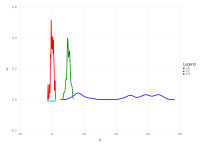

In [128]:
plotBelief(fg, [:x0, :x1, :x2])


## Adding Variable `x3`

Adding one more variable `x3` through another `LinearRelative(Normal(-50,1))`

In [129]:
addVariable!(fg, :x3, ContinuousScalar)
addFactor!(fg, [:x2, :x3], LinearRelative(Normal(-50, 1)))

DFGFactor{CommonConvWrapper{LinearRelative...}}
  timestamp:     2022-04-04T19:39:45.691-07:00
   nstime:       0 nanoseconds
  label:         x2x3f1
  solvable:      1
  VariableOrder: [:x2, :x3]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: LinearRelative{1, Normal{Float64}}
Z:
Normal{Float64}(μ=-50.0, σ=1.0)


expands the factor graph to to four variables and four factors.
This part of the tutorial shows how a unimodal likelihood (conditional belief) can transmit the bimodal belief currently contained in `:x2`.  By solving the graph, we get numerical estimates for the variables:

In [130]:
solveGraph!(fg);

Solve Progress: approx max 48, at iter 11 	 Time: 0:00:00

Solve Progress: approx max 48, at iter 15 	 Time: 0:00:00

Solve Progress: approx max 48, at iter 23 	 Time: 0:00:01


Building Bayes net...
Find potential functions for each clique


and the plotting the marginal posterior belief estimates over each variable to see what the position estimates are given available info:

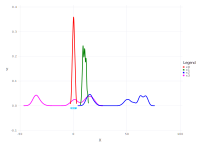

In [131]:
plotBelief(fg, [:x0, :x1, :x2, :x3])

Notice the blue trace (`x3`) is a shifted and slightly spread out version of the initialized belief on `x2`, through the convolution with the conditional belief `P(Z | X2, X3)`.

### The Last Factor


Global inference over the entire factor graph has still not occurred, and will at this stage produce roughly similar results to the predicted beliefs shown above.
Only by introducing more information into the factor graph can inference extract more precise marginal belief estimates for each of the variables.
A final piece of information added to this graph is a factor directly relating `x3` with `x0`.

In [132]:
addFactor!(fg, [:x3, :x0], LinearRelative(Normal(30, 1)))

DFGFactor{CommonConvWrapper{LinearRelative...}}
  timestamp:     2022-04-04T19:40:11.083-07:00
   nstime:       0 nanoseconds
  label:         x3x0f1
  solvable:      1
  VariableOrder: [:x3, :x0]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: LinearRelative{1, Normal{Float64}}
Z:
Normal{Float64}(μ=30.0, σ=1.0)


Pay close attention to what this last factor means in terms of the probability density traces shown in the previous figure.
The blue trace for `x3` has two major modes, one that overlaps with `x0, x1` near 0 and a second mode further to the left at -40.
The last factor introduces a shift `LinearRelative(Normal(40,1))` which essentially aligns the left most mode of `x3` back onto `x0`.

This last factor forces a mode selection through consensus.
By doing global inference, the new information obtained in `x3` will be equally propagated to `x2` where only one of the two modes will remain.

## Solve the Graph


Global inference is achieved with local computation using two function calls, as follows.


In [133]:
tree = solveGraph!(fg);

Solve Progress: approx max 48, at iter 11 	 Time: 0:00:00

Solve Progress: approx max 48, at iter 13 	 Time: 0:00:01

Solve Progress: approx max 48, at iter 23 	 Time: 0:00:01


Building Bayes net...
Find potential functions for each clique


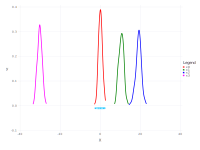

In [134]:
# and the visualization
plotBelief(fg, [:x0, :x1, :x2, :x3])

The resulting posterior marginal beliefs over all the system variables are:

In [83]:
DFG.getPPESuggested.(fg, [:x0;:x1;:x2;:x3])

4-element Vector{Vector{Float64}}:
 [-0.1467860071614139]
 [9.098210070488408]
 [10.880285041865285]
 [-39.47816305205497]

### It Did Slip!

Look, the resulting distance from `x1` to `x2` with all the data available turns out to be only a few units -- much less than the 60 units measured by the encoder, coupled with the on and off slip detection.  Our example here is constructed in such a way that when all data is considered together a clear answer can be extracted.  In real situations, the beliefs could be more nuanced -- which is all the more reason to consider non-Gaussian estimation which permanently keeps track of the nuanced features hidden in the data!

## Conclusion

It is import to note that although this tutorial ends with all marginal beliefs having near Gaussian shape and are unimodal, that the package supports multi-modal belief estimates during both the prediction and global inference processes.
In fact, many of the same underlying inference functions are involved with the automatic initialization process and the global multi-modal iSAM inference procedure.
This concludes the ContinuousScalar tutorial

In [ ]:
# Should be deleted
using DistributedFactorGraphs
vs = ls(fg)
for v in vs
  @info packVariable(fg, getVariable(fg, v))
end
#fs = lsf(fg)

## Next Steps

The next tutorial looks at missing data (a.k.a. insufficient or underdetermined) situations where all Gaussian measurements result in highly non-Gaussian and multi-modal posterior estimates.